## _*Comparing Strings with Quantum Superpositon*_ 

The latest version of this notebook is available on 

https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/hello_world/string_comparison.ipynb

For more information about how to use the IBM Q Experience (QX), consult the [tutorials](https://quantum-computing.ibm.com/lab/docs/iql/tutorials-overview), or check out the [community](https://research.ibm.com/topics/quantum-community).

### Contributors
Rudy Raymond

## _*Código modificado en la UdeA, Medellín, Colombia*_ 
 El presente código tiene múltiples cambios debido a errores presentados en la versión original de este código, especificamente en la operación de inversión de compuertas inicializadas con amplitudes complejas numéricas. Este error fue originado por una actualización en las *Class Instruction* y *Class Initialize* de la plataforma Qiskit Terra.

### Gustavo Patino
Facultad de Ingeniería

Universidad de Antioquia

Medellin, Colombia. 2020 - 2025

## Motivation

If we can use quantum states to represent genetic codes, we may be able to compare them, and/or find similar genetic codes quickly. 

For example, according to [this site](http://www.bioinformatics.org/sms2/genetic_code.html) the starts of the genetic codes for the Yeast Mitochondrial, Protozoan Mitochondrial, and Bacterial Code are respectively as follow. 

In [168]:
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"

Notice that each of the codes is represented by a bitstring of length 64. By comparing characters at the same position in the strings, we can see that Protozoan's is closer to Bacterial's than Yeast's. 

Exploiting quantum superposition, we can create quantum states by using only 7 qubits such that each of the quantum states corresponds to the genetic code of Yeast, Protozoan, and Bacterial. We then compare the closeness of their genetic codes by comparing their quantum states, which is made possible by the reversibility of quantum circuit.

The reversibility of quantum circuit to test the similarity of quantum states works as follow. Assume that we can create a quantum superposition starting from all-zero states by a quantum circuit. Then by inverting the same quantum circuit and we give it the same quantum superposition as input, we will get exactly all-zero bits as the output. Now, when we give a similar quantum superposition as input to the inverted circuit, we can still get all-zero bits as the output with probability proportional to the similarity of the quantum states: the more similar, the more we observe all-zero bits. 

Thus, to decide which code (*Yeast's* *or* *Bacterial's*) is the most similar to the Protozoan, we can do the following:

1. We first prepare the quantum state that encodes the Protozoan's
2. We then use the quantum state as inputs to the inverted circuits that each prepare the quantum state of Yeast's and Bacterial's. Run and measure the circuits
3. Output the name of the inverted circuit whose measurements result in more frequent measurements of all-zero bits. 


## Quantum Superposition for Bitstrings

A qubit can be in a superposition of two basis states: "0" and "1" at the same time. Going further, two qubits can be in a superposition of four basis states: "00", "01", "10", and "11". In general, $n$ qubits can be in a superposition of $2^n$ (exponential in the number of qubits!) basis states. 

Here, we show a simple example to create quantum superpositon for bitstrings and use them to compare the similarity between two bitstrings. This tutorial makes use the [quantum state initialization function](https://nbviewer.jupyter.org/github/QISKit/qiskit-tutorial/blob/master/reference/tools/quantum_gates_and_linear_algebra.ipynb#Arbitrary-initialization) and **circuit inversion**. It also illustrates the power of loading data into quantum states. 

## Comparing bitstrings of length 64 with 7 qubits

Let say we have three genetic codes as above.

```
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"
```

Let use 7 qubits to encode the above codes: the first 6 qubits for indexing the location in the code (because we have 64 positions that we number from 0 to 63), and the last qubit for the content of the code (we use "0" for "-" and "1" for "M"). Thus, numbering the position of the code from left to right, we can create quantum states for each of the code as below: 

\begin{align}
|YEAST \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle  + |000010\rangle |0\rangle + |000011\rangle |0\rangle + \ldots \right) \\
|PROTOZOAN \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle + |000010\rangle |1\rangle + |000011\rangle |1\rangle + \ldots \right) \\
|BACTERIAL \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle + |000010\rangle |0\rangle + |000011\rangle |1\rangle + \ldots \right)
\end{align}

The first four codes of Yeast's are all "-", and therefore at the above all of the second registers of the corresponding state are "0". And so on. 

### Creating quantum superposition for genetic codes

Below is the python function to create a quantum superposition for a given genetic code as above. 

In [169]:
import sys
import numpy as np
import math

In [170]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# , execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# from qiskit.extensions import Initialize
from qiskit.circuit.library import Initialize

from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Statevector

In [185]:
print(YEAST)
len(YEAST)

----------------------------------MM----------------------------


64

In [172]:
# # Define a state to initialize
# state = [1/2, 1/2, 1/2, 1/2]  # 2-qubit uniform superposition

# # Create the Initialize gate
# init = Initialize(state)

# # Create a circuit and append the initialization
# qc = QuantumCircuit(2)
# qc.append(init, [0, 1])

# # Apply some operations (optional)
# qc.h(0)
# qc.cx(0, 1)

# # Now get the uncompute circuit from the Initialize object
# uncompute = init.gates_to_uncompute()

# # Append the uncompute circuit to revert the initialization
# qc.append(uncompute, [0, 1])

# # Draw the circuit
# qc.draw('mpl')

### Cambio realizado UdeA 2020 - 2025
En la definición de la siguiente función se encuentran los cambios que fueron necesarios para corregir el error presentado.

In [173]:
def encode_bitstring(bitstring, qr, cr, inverse=False):
    """
    create a circuit for constructing the quantum superposition of the bitstring
    """
    n = math.ceil(math.log2(len(bitstring))) + 1                 #number of qubits
    assert n > 2, "the length of bitstring must be at least 2"
    
    qc = QuantumCircuit(qr, cr)
    
    #the probability amplitude of the desired state
    desired_vector = np.array([ 0.0 for i in range(2**n) ])     #initialize to zero

    print(len(desired_vector))

    display(array_to_latex(Statevector(desired_vector), prefix="\\ket{\\psi_1} = "))
################################################################################################################    
 #         Cambio requerido en el código para corregir error presentado   #
    
    qc_init = QuantumCircuit(n) # Creación de compuertas circuitales para inicialización
    inverse_qc_init = QuantumCircuit(n) # Creación de compuertas circuitales para inversión de la inicialización

################################################################################################################

    amplitude = np.sqrt(1.0/2**(n-1))
    
    for i, b in enumerate(bitstring):
        print(i)
        pos = i * 2
        if b == "1" or b == "M":
            print("b =", b)
            pos += 1
        desired_vector[pos] = amplitude

    print(desired_vector)

    display(array_to_latex(Statevector(desired_vector), prefix="\\ket{\\psi_2} = "))
    print(type(desired_vector))

################################################################################################################    
 #         Cambio requerido en el código para corregir error presentado   #
    
    init = Initialize(desired_vector)
    
 ################################################################################################################       
    
    if not inverse:
        # qc.initialize(desired_vector, qr)

        qc_init.append(init, qc_init.qubits)
        qc.append(qc_init, qr)  #  Cambio requerido en el código para corregir error presentado   #
    
        qc.barrier(qr)
        
    else:
        uncompute = init.gates_to_uncompute()

        inverse_qc_init.append(uncompute, inverse_qc_init.qubits)
        qc.append(inverse_qc_init, qr)  # Cambio requerido en el código para corregir error presentado   #
        
        qc.barrier(qr)
        for i in range(n):
            qc.measure(qr[i], cr[i])
    print()
    return qc

We can now create quantum circuits to create the quantum states for the Yeast's, Protozoan's, and Bacterial's.

In [174]:
n = math.ceil(math.log2(len(YEAST))) + 1                 #number of qubits
qr = QuantumRegister(n)
cr = ClassicalRegister(n)

qc_yeast     = encode_bitstring(YEAST, qr, cr)
qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr)
qc_bacterial = encode_bitstring(BACTERIAL, qr, cr)

circs = {"YEAST": qc_yeast, "PROTOZOAN": qc_protozoan, "BACTERIAL": qc_bacterial}

128


<IPython.core.display.Latex object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
b = M
35
b = M
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
[0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.    0.125
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.   ]


<IPython.core.display.Latex object>

<class 'numpy.ndarray'>

128


<IPython.core.display.Latex object>

0
1
2
b = M
3
b = M
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
b = M
20
21
22
23
24
25
26
27
28
29
30
31
32
b = M
33
b = M
34
b = M
35
b = M
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
b = M
52
53
54
55
56
57
58
59
60
61
62
63
[0.125 0.    0.125 0.    0.    0.125 0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.    0.125 0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.    0.125 0.    0.125 0.    0.125 0.    0.125
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.   ]


<IPython.core.display.Latex object>

<class 'numpy.ndarray'>

128


<IPython.core.display.Latex object>

0
1
2
3
b = M
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
b = M
20
21
22
23
24
25
26
27
28
29
30
31
32
b = M
33
b = M
34
b = M
35
b = M
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
b = M
52
53
54
55
56
57
58
59
60
61
62
63
[0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.    0.125 0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.    0.125 0.    0.125 0.    0.125 0.    0.125
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.   ]


<IPython.core.display.Latex object>

<class 'numpy.ndarray'>



In [175]:
# qc_bacterial.decompose(reps=5).draw('mpl')


Circuit: YEAST


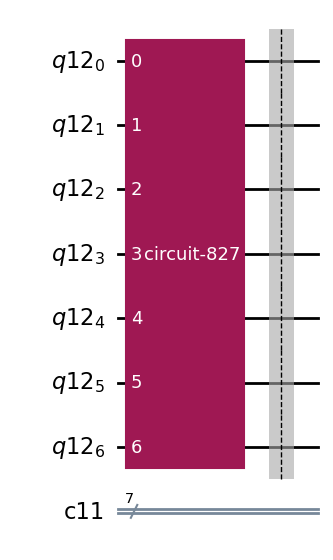


Circuit: PROTOZOAN


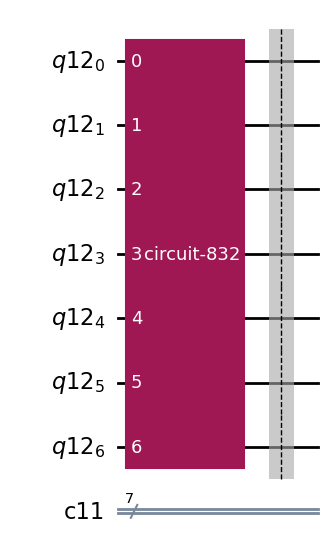


Circuit: BACTERIAL


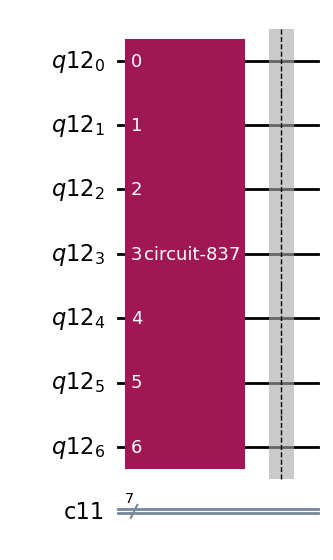

In [176]:
# from qiskit.visualization import circuit_drawer

# circs = {
#     "YEAST": qc_yeast,
#     "PROTOZOAN": qc_protozoan,
#     "BACTERIAL": qc_bacterial
# }

for name, circuit in circs.items():
    print(f"\nCircuit: {name}")
    display(circuit.draw(output='mpl'))  # Use 'mpl' for better-looking diagrams (requires matplotlib)


### Inverting quantum circuit

We can easily invert a quantum circuit by `inverse()` function. These inversed circuits are desirable to compute the closeness of the quantum states. 

In [177]:
inverse_qc_yeast     = encode_bitstring(YEAST,     qr, cr, inverse=True)
inverse_qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr, inverse=True)
inverse_qc_bacterial = encode_bitstring(BACTERIAL, qr, cr, inverse=True)

inverse_circs = {"YEAST": inverse_qc_yeast, "PROTOZOAN": inverse_qc_protozoan, "BACTERIAL": inverse_qc_bacterial}

128


<IPython.core.display.Latex object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
b = M
35
b = M
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
[0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.    0.125
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.   ]


<IPython.core.display.Latex object>

<class 'numpy.ndarray'>

128


<IPython.core.display.Latex object>

0
1
2
b = M
3
b = M
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
b = M
20
21
22
23
24
25
26
27
28
29
30
31
32
b = M
33
b = M
34
b = M
35
b = M
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
b = M
52
53
54
55
56
57
58
59
60
61
62
63
[0.125 0.    0.125 0.    0.    0.125 0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.    0.125 0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.    0.125 0.    0.125 0.    0.125 0.    0.125
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.   ]


<IPython.core.display.Latex object>

<class 'numpy.ndarray'>

128


<IPython.core.display.Latex object>

0
1
2
3
b = M
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
b = M
20
21
22
23
24
25
26
27
28
29
30
31
32
b = M
33
b = M
34
b = M
35
b = M
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
b = M
52
53
54
55
56
57
58
59
60
61
62
63
[0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.    0.125 0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.    0.125 0.    0.125 0.    0.125 0.    0.125
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.    0.125 0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.    0.125 0.
 0.125 0.    0.125 0.    0.125 0.    0.125 0.   ]


<IPython.core.display.Latex object>

<class 'numpy.ndarray'>



### Comparing bitsrings

We can now compare how close the starts of the genetic codes of Protozoan to Yeast's and Bacterial's by performing the test.

In [178]:
from qiskit_aer import AerSimulator

In [179]:
simulator = AerSimulator()

In [180]:
key = "PROTOZOAN"       #the name of the code used as key to find similar ones

In [181]:
# # use local simulator
# backend = BasicAer.get_backend("qasm_simulator")
shots = 8192

combined_circs = {}
count = {}

most_similar, most_similar_score = "", -1.0

In [182]:
from qiskit import QuantumCircuit, transpile

In [183]:
for other_key in inverse_circs:
    if other_key == key:
        continue
        
    combined_circs[other_key] = circs[key].compose(inverse_circs[other_key])   #combined circuits to look for similar codes

    job = simulator.run(transpile(combined_circs[other_key], simulator), shots=shots)
    # job.result().get_counts(qc)

    # job = execute(combined_circs[other_key], backend=backend,shots=shots)
    st = job.result().get_counts(combined_circs[other_key])
    
    if "0"*n in st:
        sim_score = st["0"*n]/shots
    else:
        sim_score = 0.0
    
    print("Similarity score of",key,"and",other_key,"is",sim_score)
    if most_similar_score < sim_score:
        most_similar, most_similar_score = other_key, sim_score

print("[ANSWER]", key,"is most similar to", most_similar)

Similarity score of PROTOZOAN and YEAST is 0.8260498046875
Similarity score of PROTOZOAN and BACTERIAL is 0.9693603515625
[ANSWER] PROTOZOAN is most similar to BACTERIAL


We observe that the test can be used to determine which code is closer: bacterial's is closer to protozoan's than yeast's. 

There are many other genetic codes listed at [bioinformatics.org](http://www.bioinformatics.org/sms2/genetic_code.html) which can be used as input strings. In general, DNA has four nucleotides: "A", "C", "G", and "T". Thus, instead of one qubit like in this notebook, two qubits are required to encode the nucleotides. However, the asymptotic amount of quantum bits for encoding the whole sequence of length $N$ is still in the order of $\log{N}$, which is exponentially small. 

## Deep Dive

The technique of using circuit inversion to measure how close two quantum states has been used in many literature. For example, it is used for Quantum Kernel Estimation in [Havlicek et al., 2018](https://arxiv.org/pdf/1804.11326.pdf) for supervised learning. The idea of using quantum superposition to encode bistrings appeared in [Quantum Fingerprinting](https://arxiv.org/pdf/quant-ph/0102001.pdf) where a quantum exponential advantage is shown for a communication task of comparing two bitstrings. 

The intuition of why combining a circuit which creates a quantum state with another circuit which is the inverted circuit of creating another quantum state can be used to measure how close two quantum states is as follow. 

All operations (except measurements) in quantum computers are unitary and hence, distance preserving. This means if we apply the same operation (or, circuit) to two states that are similar, the resulting states will also be similar. All those operations are also reversible, that means, if we know a circuit $C$ to create a particular quantum state $|\phi\rangle$ from the all-zero state, we can also design the circuit $C'$ that transforms back the quantum state $|\phi\rangle$ to the all-zero state. Now, if we apply $C'$ to a quantum state $|\psi\rangle$ which is similar to $|\phi\rangle$, we will obtain a quantum state which is also similar to the all-zero state. The distance of the resulting state to the all-zero state is the same as the distance between  $|\phi\rangle$ and $|\psi\rangle$. 


We can notice that the similarity of two different quantum states can be very close to zero, and thus making difficult to find the discrepancies. However, we can use encoding techniques, such as, by [employing repetition code](https://arxiv.org/abs/1709.00990), to guarantee that different quantum states are separated far enough. In general, we can exploit error correcting codes, such as, [Justesen code](https://en.wikipedia.org/wiki/Justesen_code), or [locality-sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) to encode bitstrings efficiently. 

In [184]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

ModuleNotFoundError: No module named 'qiskit.tools'